# Demo: Using Pretrained EpiAgent for Zero-Shot Cell Embeddings on Kanemaru2023 Dataset

This notebook demonstrates the use of the pretrained EpiAgent model, which has been trained on the large-scale Human-scATAC-Corpus with approximately 5 million cells and 35 billion tokens. It illustrates a zero-shot inference workflow to extract cell embeddings from the downsampled Kanemaru2023 dataset (Kanemaru2023_downsampled_10000_cells.h5ad).

Required files:

	•	pretrained_EpiAgent.pth: The pretrained EpiAgent model.
	•	Kanemaru2023_downsampled_10000_cells.h5ad: The downsampled Kanemaru2023 dataset.

These files are available at the following link: https://drive.google.com/drive/folders/1WlNykSCNtZGsUp2oG0dw3cDdVKYDR-iX?usp=sharing.

# Step 1: Data Processing (TFIDF and Tokenization)

To prepare the Kanemaru2023 dataset for EpiAgent, we perform the following preprocessing steps:

1.TFIDF Transformation: Convert discrete count data into continuous importance scores for accessible cCREs.
    
2.Tokenization: Generate cell_sentences to represent each cell as a sequence of accessible cCRE indices.

In [1]:
import scanpy as sc
import numpy as np
from epiagent.tokenization import tokenization
from epiagent.preprocessing import global_TFIDF

# Load the dataset
input_path = '../data/sample/raw_h5ad/Kanemaru2023_downsampled_10000_cells.h5ad'
adata = sc.read_h5ad(input_path)

# Load the cCRE document frequency data
cCRE_document_frequency = np.load('../data/cCRE_document_frequency.npy')

# Apply TFIDF transformation
global_TFIDF(adata, cCRE_document_frequency)

# Perform tokenization
tokenization(adata)

Tokenization complete: 'cell_sentences' column added to adata.obs.


# Step 2: Create Dataset and DataLoader

We create a PyTorch-compatible Dataset and DataLoader to handle tokenized cell_sentences from the processed AnnData object. Each cell is represented as a sequence of tokens with special tokens [CLS] and [SEP].

In [2]:
from epiagent.dataset import CellDataset, collate_fn
from torch.utils.data import DataLoader

# Create the dataset
cell_sentences = adata.obs['cell_sentences'].tolist()
cell_dataset = CellDataset(cell_sentences=cell_sentences)

# Create the DataLoader
batch_size = 8
dataloader = DataLoader(cell_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

# Step 3: Load Pretrained EpiAgent Model

The pretrained EpiAgent model (pretrained_EpiAgent.pth) is loaded for zero-shot inference to compute cell embeddings.

In [3]:
from epiagent.model import EpiAgent
import torch

# Load the pretrained model
model_path = '../model/pretrained_EpiAgent.pth'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pretrained_model = EpiAgent(vocab_size=1355449, num_layers=18, embedding_dim=512, num_attention_heads=8, max_rank_embeddings=8192, use_flash_attn=True, pos_weight_for_RLM=torch.tensor(1.), pos_weight_for_CCA=torch.tensor(1.))
pretrained_model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

# Step 4: Extract Cell Embeddings


The infer_cell_embeddings function is used to compute cell embeddings using the pretrained EpiAgent model.

In [4]:
from epiagent.inference import infer_cell_embeddings

# Extract cell embeddings
cell_embeddings = infer_cell_embeddings(pretrained_model, device, dataloader)

# Step 5: UMAP Visualization

Perform UMAP visualization to project the embeddings into a 2D space.

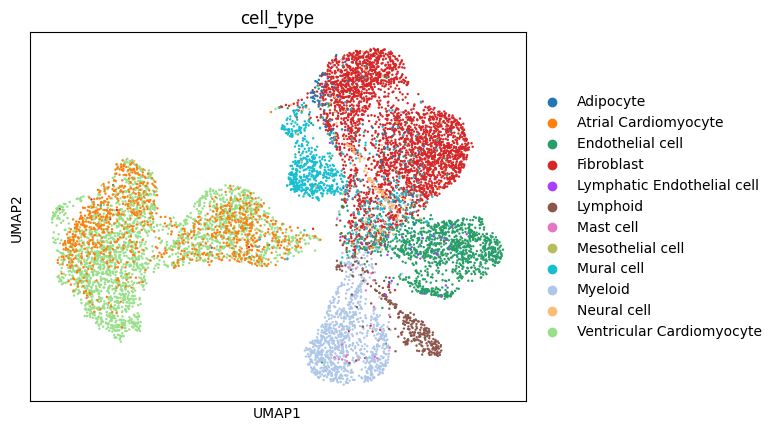

In [5]:
import scanpy as sc

# Assign embeddings to the AnnData object
adata.obsm['cell_embeddings_zero_shot'] = cell_embeddings

# UMAP visualization
sc.pp.neighbors(adata, use_rep='cell_embeddings_zero_shot')
sc.tl.umap(adata)

# Plot UMAP with original cell types
sc.pl.umap(adata, color='cell_type')

# # Save the processed AnnData
# output_path = '../data/sample/processed_h5ad/Kanemaru2023_downsampled_10000_cells_EpiAgent_zero_shot_outputs.h5ad'
# adata.write(output_path)
# print(f"Processed AnnData saved at {output_path}")

In [7]:
pretrained_model.criterion_CCA.pos_weight

tensor(5., device='cuda:0')